## What is the true normal human body temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. In 1992, this value was revised to 36.8$^{\circ}$C or 98.2$^{\circ}$F. 

#### Exercise
In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.

Answer the following questions **in this notebook below and submit to your Github account**. 

1.  Is the distribution of body temperatures normal? 
    - Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply. 
2.  Is the true population mean really 98.6 degrees F?
    - Bring out the one sample hypothesis test! In this situation, is it approriate to apply a z-test or a t-test? How will the result be different?
3.  At what temperature should we consider someone's temperature to be "abnormal"?
    - Start by computing the margin of error and confidence interval.
4.  Is there a significant difference between males and females in normal temperature?
    - Set up and solve for a two sample hypothesis testing.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
%matplotlib inline
from matplotlib import pyplot as plot
import pandas as pd
from scipy import stats
from statsmodels.api import qqplot
import numpy as np

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')

In [3]:
# adding temp in degrees celsius
df['tempC'] = df.temperature.apply(lambda x: (x-32)*(5/9.))

#### Quick summary statistics

In [4]:
df.describe().apply(lambda x: np.round(x,2))

,temperature,heart_rate,tempC
count,130.00,130.00,130.00
mean,98.25,73.76,36.81
std,0.73,7.06,0.41
min,96.30,57.00,35.72
25%,97.80,69.00,36.56
50%,98.30,74.00,36.83
75%,98.70,79.00,37.06
max,100.80,89.00,38.22


In [5]:
df.groupby("gender").describe().apply(lambda x: np.round(x,2))

heart_rate  tempC  temperature
gender                                      
F      count       65.00  65.00        65.00
       mean        74.15  36.89        98.39
       std          8.11   0.41         0.74
       min         57.00  35.78        96.40
       25%         68.00  36.67        98.00
       50%         76.00  36.89        98.40
       75%         80.00  37.11        98.80
       max         89.00  38.22       100.80
M      count       65.00  65.00        65.00
       mean        73.37  36.72        98.10
       std          5.88   0.39         0.70
       min         58.00  35.72        96.30
       25%         70.00  36.44        97.60
       50%         73.00  36.72        98.10
       75%         78.00  37.00        98.60
       max         86.00  37.50        99.50


Notably the mean temperature rounds to roughly 37 °C, which then converts to 98.6, suggesting the 98.6 value may be a result of rounding followed by conversion, rather than  conversion followed by rounding.

## Q1: Checking for approximate normality
Using a q-q plot here

normal q-q plot for the sample


/home/chirp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


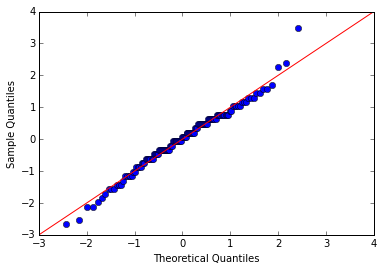

In [6]:
# ignore error message. without the .show() qqplot has some buggy behavior when run with %matplotlib inline
print "normal q-q plot for the sample"
qqplot(df.temperature,line='45',fit=True).show()

The majority of the data appears to fit the normal distribution relatively well. However, the lowest and highest quantiles show less of a good fit. There's also some apparent discreetness in the data, which apparently arises from rounding in the original data (see documentation). Splitting by gender, the women show less of a good fit to the normal distribution than men.

normal q-q plot for women in the sample


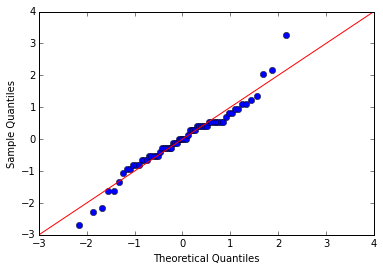

In [7]:
print "normal q-q plot for women in the sample"
qqplot(df[df.gender=="F"].temperature,line='45',fit=True).show()

normal q-q plot for men in the sample


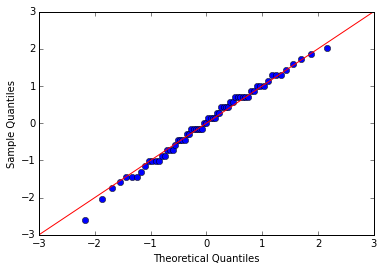

In [8]:
print "normal q-q plot for men in the sample"
qqplot(df[df.gender=="M"].temperature,line='45',fit=True).show()

#### Histograms

Upper histogram is the distribution for women, lower for men.

gender
F    [[Axes(0.125,0.563043;0.775x0.336957)], [Axes(...
M    [[Axes(0.125,0.563043;0.775x0.336957)], [Axes(...
dtype: object

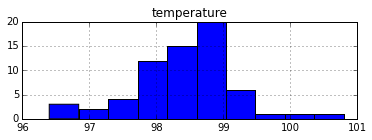

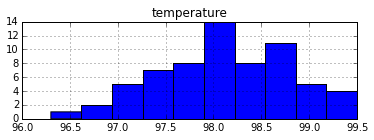

In [9]:
df.groupby("gender").hist(column=["temperature"],layout=(2,1),sharex=True)

These aren't precisely normal looking, women moreso than men, but they aren't particularly badly off. However, given that the normality assumption is maybe not totally justified here, a t test might be more appropriate than a z test, being more robust with regard to this assumption.

##### Checking for relationship between heart rate and temperature
Plot below suggests not *too* much going on with this.

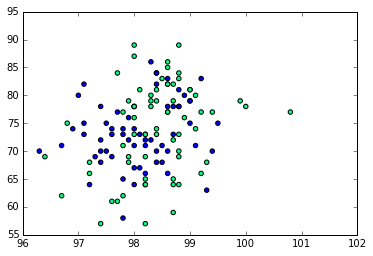

In [10]:
genderBin = np.where(df.gender=="F",1,0)
genderBin
plot.scatter(df.temperature,df.heart_rate,c=genderBin,cmap='winter')

#### Slightly more formally:

In [11]:
print "Correlation between heart rate and temperature is %.3f (p = %.3f)" %stats.pearsonr(df.temperature,df.heart_rate)

Correlation between heart rate and temperature is 0.254 (p = 0.004)


So the relationship is significant and is large enough that it isn't necessarily something to be ignored. While some of this might be attributed to the gender differences in heart rate, there's a still a lot of overlap. Will address this is a bit more detail below.

# Q2: Is mean body temp 98.6 °F?

In [12]:
ttest1 = stats.ttest_1samp(df.temperature,98.6)
print "The t-statistic is %.3f and the p-value is %s" % ttest1

The t-statistic is -5.455 and the p-value is 2.41063204156e-07


So, the mean here is significantly different from 98.6. This is not particularly shocking, given the mean of 98.25 calculated above. Constructing a 95% confidence interval around the mean, we find that it doesn't contain 98.6

In [13]:
n = len(df.temperature)
m = df.temperature.mean()
se = stats.sem(df.temperature)
h = se * stats.t.ppf(0.975, n-1)
print "Lower: %.2f, Upper: %.2f" %(m-h,m+h)

Lower: 98.12, Upper: 98.38


For comparison, a z-test gives quite similar answers:

In [14]:
from statsmodels.stats.weightstats import ztest
ztest(x1=df.temperature,value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

In [15]:
np.array(df.temperature)

array([  99.3,   98.4,   97.8,   99.2,   98. ,   99.2,   98. ,   98.8,
         98.4,   98.6,   98.8,   96.7,   98.2,   98.7,   97.8,   98.8,
         98.3,   98.2,   97.2,   99.4,   98.3,   98.2,   98.6,   98.4,
         97.8,   98. ,   97.8,   98.2,   98.4,   98.1,   98.3,   97.6,
         98.5,   98.6,   99.3,   99.5,   99.1,   98.3,   97.9,   96.4,
         98.4,   98.4,   96.9,   97.2,   99. ,   97.9,   97.4,   97.4,
         97.9,   97.1,   98.9,   98.3,   98.5,   98.6,   98.2,   98.6,
         98.8,   98.2,   98.2,   97.6,   99.1,   98.4,   98.2,   98.6,
         98.7,   97.4,   97.4,   98.6,   98.7,   98.9,   98.1,   97.7,
         98. ,   98.8,   99. ,   98.8,   98. ,   98.4,   97.4,   97.6,
         98.8,   98. ,   97.5,   99.2,   98.6,   97.1,   98.6,   98. ,
         98.7,   98.1,   97.8,  100. ,   98.8,   97.1,   97.8,   96.8,
         99.9,   98.7,   98.8,   98. ,   99. ,   98.5,   98. ,   99.4,
         97.6,   96.7,   97. ,   98.6,   98.7,   97.3,   98.8,   98. ,
      

# Q3: What counts as normal?

This is fairly difficult to say. Assuming nobody in the sample was seriously ill when the measurements were taken, there's a non-trivial range of variability (sample values range between 96 and 100 °F). Given that the distribution is roughly normal, 2 sds from the mean might be a useful guideline. This would give the range 96.79 to 99.71 °F, corresponding fairly well to Wikipedia's [listed values](https://en.wikipedia.org/wiki/Human_body_temperature) for the observed range.

# Q4: Gender differences?

Do women and men show a difference in mean body temperature?

In [16]:
fTemp = df[df["gender"] == "F"].temperature
mTemp = df[df["gender"] == "M"].temperature
ttest2 = stats.ttest_ind(fTemp,mTemp)
print "The difference in means is %.3f degrees" % (fTemp.mean() - mTemp.mean())
print "The t-statistic is %.3f and the p-value is %.3f" % ttest2

The difference in means is 0.289 degrees
The t-statistic is 2.285 and the p-value is 0.024


So, the (small) differences in the estimated means calculated above also appear to be significant, although for the data shows a lot of overlap (see summary statistics above).

## Taking into account heart rate:

In [17]:
import statsmodels.formula.api as smf

In [18]:
lm = smf.ols(formula='temperature ~ heart_rate + gender', data=df).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.919
Date:                Mon, 09 Nov 2015   Prob (F-statistic):            0.00141
Time:                        18:47:28   Log-Likelihood:                -136.89
No. Observations:                 130   AIC:                             279.8
Df Residuals:                     127   BIC:                             288.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      96.5202      0.656    147.240      

Having heart rate and gender both in the model does not result in either individual effect vanishing suggesting that controlling for heart rate still leaves a gender difference (although some complications arise with interactions).

Interpretation of the heart rate effect is a bit tricky. One possibility is that an elevated heart rate results in a raised body temperature. Alternatively, possibly higher temperature elevates the heart rate as some sort of physiological response.